# 0. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score 

import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost", xgboost.__version__)
print("imblearn: ", imblearn.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost 2.0.3
imblearn:  0.10.1


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
train = pd.read_csv("../data/hr_train_scaling.csv",
                    index_col = 0)

test = pd.read_csv("../data/hr_test_scaling.csv",
                    index_col = 0)

In [5]:
train.head(2)

,job_satisfaction,working_hours,num_companies_worked,age,years_at_company,salary_increasing_rate,department_hr,department_rnd,department_sales,marital_status_etc,marital_status_married,marital_status_single,attrition
1274,1.000000,0.356223,0.111111,0.309524,0.325,0.558212,0.0,0.0,1.0,0.0,1.0,0.0,0
1080,0.333333,0.858369,0.888889,0.666667,0.575,0.492676,0.0,0.0,1.0,0.0,1.0,0.0,0


In [6]:
x_train = train[train.columns[:-1]].values
y_train = train["attrition"].values

x_test = test[test.columns[:-1]].values
y_test = test["attrition"].values

In [7]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([919, 175], dtype=int64))

# 1. Sampling: ENN, SMOTE, SMOTEENN

In [8]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(x_train, y_train)

np.unique(y_enn, return_counts=True)

(array([0, 1], dtype=int64), array([501, 175], dtype=int64))

In [9]:
smo = SMOTE(random_state=0)
x_smo, y_smo = smo.fit_resample(x_train, y_train)

np.unique(y_smo, return_counts=True)

(array([0, 1], dtype=int64), array([919, 919], dtype=int64))

In [10]:
smoenn = SMOTEENN(random_state=0)
x_smoenn, y_smoenn = smoenn.fit_resample(x_train, y_train)

np.unique(y_smoenn, return_counts=True)

(array([0, 1], dtype=int64), array([479, 744], dtype=int64))

# 2. Model

* 240531_02_confusion_matrix.ipynb 참고
* HR 데이터에 여러 모델을 적용했을 때 recall이 가장 높았던 모델은 DT였다!

In [11]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
accuracy_score(pred_tree, y_test)

0.7671232876712328

In [12]:
tree_enn = DecisionTreeClassifier(random_state = 42)
tree_enn.fit(x_enn, y_enn)
pred_enn = tree_enn.predict(x_test)
accuracy_score(pred_enn, y_test)

0.6438356164383562

In [13]:
tree_smo = DecisionTreeClassifier(random_state = 42)
tree_smo.fit(x_smo, y_smo)
pred_smo = tree_smo.predict(x_test)
accuracy_score(pred_smo, y_test)

0.6958904109589041

In [14]:
tree_smoenn = DecisionTreeClassifier(random_state = 42)
tree_smoenn.fit(x_smoenn, y_smoenn)
pred_smoenn = tree_smoenn.predict(x_test)
accuracy_score(pred_smoenn, y_test)

0.6520547945205479

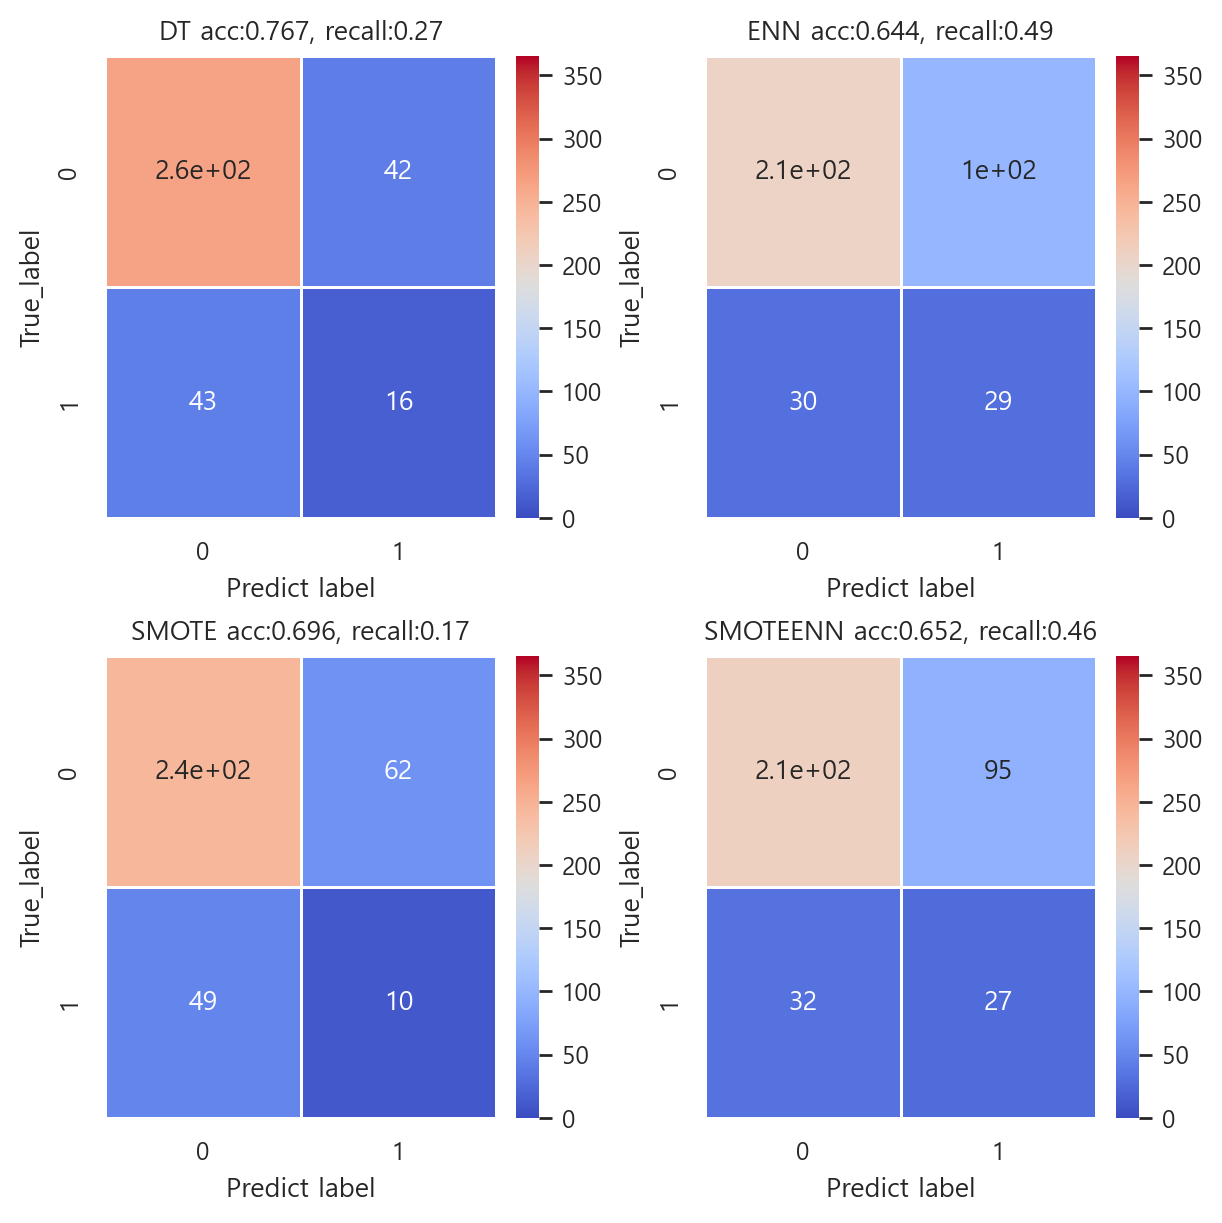

In [15]:
## 각 샘플링을 통한 모델 분류 결과를 heatmap으로 그리시오.

fig, axes = plt.subplots(2, 2, figsize=(6,6))

pred_dict = {"DT": pred_tree,
             "ENN": pred_enn,  
             "SMOTE": pred_smo,   
             "SMOTEENN": pred_smoenn
            }

for name, ax in zip(pred_dict.keys(), axes.flat):
    matrix = pred_dict[name]
    acc = round(accuracy_score(pred_dict[name], y_test), 3)
    recall = round(recall_score(y_test, pred_dict[name]), 2)
    
    sns.heatmap(data = confusion_matrix(y_test, matrix), 
                cmap = "coolwarm",
                linecolor="white",
                linewidth=1,
                annot=True,
                vmax = 365, #변경
                vmin = 0,
                ax=ax)
    title = f"{name} acc:{acc}, recall:{recall}" 
    ax.set(xlabel = "Predict label", ylabel = "True_label", title = title)

# 3. AUC-ROC Curve

* 이진분류 모델의 성능평가에 사용
* FPR이 변할 때 TPR이 어떻게 변하는지를 그린 그래프

* TPR(True Positive Rate) = recall = 재현율 = 민감도

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{FN+TP}}
\end{equation}

* TNR(True Negative Rate) = specificity = 특이성

\begin{equation}
\text{TNR} = \frac{\text{TN}}{\text{TN+FP}}
\end{equation}

* FPR(False Positive Rate) = $1-$특이성

\begin{align}
\text{FPR} &= 1-\text{TNR}\\
&=\frac{\text{FP}}{\text{TN+FP}}
\end{align}

In [16]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       306
           1       0.28      0.27      0.27        59

    accuracy                           0.77       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.77      0.77       365



In [17]:
# sklearn으로 ROC curve 그리기
# DT와 XGBoost 비교

tree_fpr, tree_tpr, tree_thr = roc_curve(y_test, tree.predict_proba(x_test)[:,1])
tree_enn_fpr, tree_enn_tpr, tree_enn_thr = roc_curve(y_test, tree_enn.predict_proba(x_test)[:,1])

In [18]:
tree_fpr

array([0.       , 0.1372549, 1.       ])

In [19]:
tree_thr

array([2., 1., 0.])

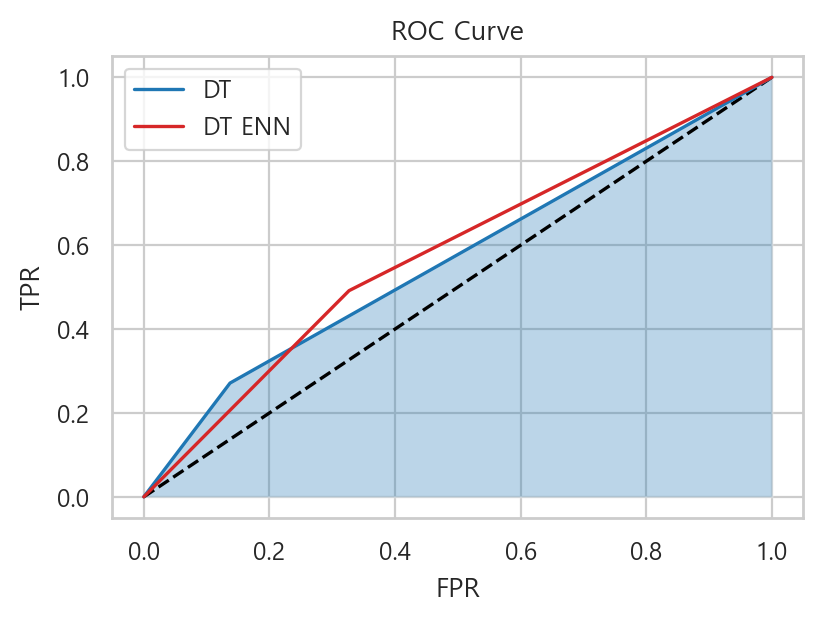

In [20]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1], [0,1], "k--")
ax.plot(tree_fpr, tree_tpr, label="DT", color = "tab:blue")
ax.plot(tree_enn_fpr, tree_enn_tpr, label="DT ENN", color = "tab:red")

ax.fill_between(tree_fpr, tree_tpr, facecolor='tab:blue', alpha=0.3)

ax.set(xlabel="FPR", ylabel="TPR", title = "ROC Curve")
ax.legend();

* AUC score: ROC 커브의 아래 면적
* 정확도가 비슷하다면 넓을수록 좋은 모델이라고 판단

In [21]:
print("AUC score of DT:", roc_auc_score(y_test, tree.predict_proba(x_test)[:,1]))
print("AUC score of DT ENN:", roc_auc_score(y_test, tree_enn.predict_proba(x_test)[:,1]))

AUC score of DT: 0.566965769358591
AUC score of DT ENN: 0.5823640190539493


**직접 그려보면?**

In [27]:
confusion_matrix(y_test, pred_tree)

array([[264,  42],
       [ 43,  16]], dtype=int64)

In [29]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       306
           1       0.28      0.27      0.27        59

    accuracy                           0.77       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.77      0.77       365



In [33]:
thr = 0.3
pred_thr = tree.predict_proba(x_test)[:,1]>thr

tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])
    
print("TPR: ", tp/(fn+tp))
print("FPR: ", fp/(tn+fp))

TPR:  0.2711864406779661
FPR:  0.13725490196078433


In [34]:
# thr를 0부터 1까지 0.1씩 증가시키며 tpr과 fpr을 계산
tpr = [1]
fpr = [1]
for thr in np.arange(0, 1.1, 0.1):
    pred_thr = tree.predict_proba(x_test)[:,1]>thr

    tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
    fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
    fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
    tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])
    
    tpr.append(tp/(fn+tp))
    fpr.append(fp/(tn+fp))

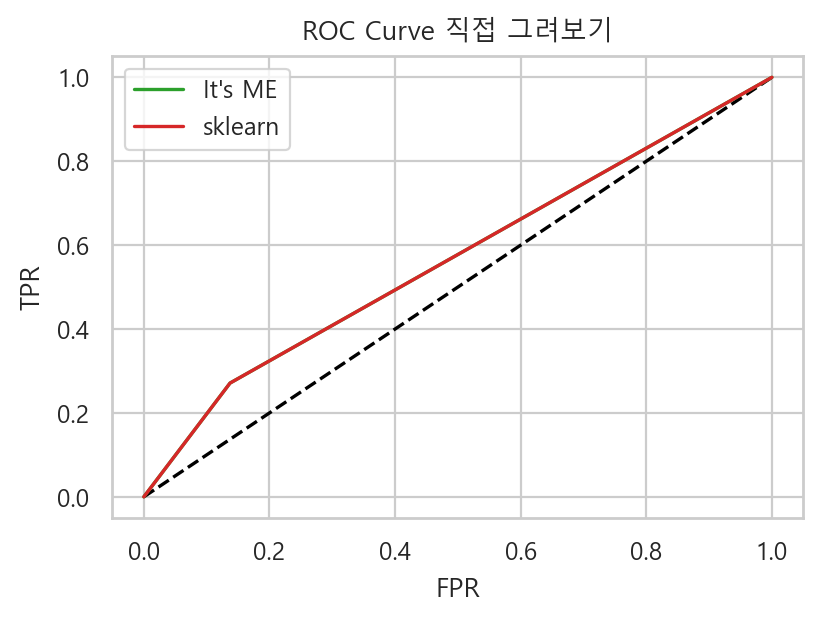

In [35]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1], [0,1], "k--")
ax.plot(fpr, tpr, label="It's ME", color = "tab:green")
ax.plot(tree_fpr, tree_tpr, label="sklearn", color = "tab:red")

ax.set(xlabel="FPR", ylabel="TPR", title = "ROC Curve 직접 그려보기")
ax.legend();

* 대각선으로 그린 검은 점선보다 roc 커브가 아래 쪽에 그려진다면 그 모델은 사용할 수 없는 모델
* TPR 쪽으로 가까워질수록 좋은 모델이라고 평가

* 총 테스트 데이터의 샘플 수: $N$
* 테스트 데이터 중 class 0의 샘플 수: $\alpha$
* 테스트 데이터 중 class 1의 샘플 수: $N-\alpha$

어떤 모델이 출력 결과에 대해 $\rho$의 확률로 class 1을, $1-\rho$의 확률로 class 0을 출력한다고 가정하자. 


* TN = $\alpha\cdot(1-\rho)$
* FP = $\alpha\cdot\rho$
* FN = $(N-\alpha)\cdot(1-\rho)$
* TP = $(N-\alpha)\cdot\rho$

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{FN}+\text{TP}} = \frac{(N-\alpha)\cdot\rho}{(N-\alpha)\cdot(1-\rho)+(N-\alpha)\cdot\rho} = \rho
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{TN}+\text{FP}} = \frac{\alpha\cdot\rho}{\alpha\cdot(1-\rho)+\alpha\cdot\rho} = \rho
\end{equation}

이 경우의 
* ROC curve: 검은 점선
* AUC score: 0.5

따라서 모델을 학습 시킨 후 roc 커브의 그래프는 적어도 점선의 직선보다 크게 그려져야 하고, 면적은 0.5를 넘어야